## I. Import Libraries and Data

In [1]:
import re
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tpot import TPOTClassifier
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import coo_matrix, hstack
from scipy.sparse import csr_matrix, hstack

from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

## II. Define Functions

## A. Cleaning and Read Functions

In [2]:
def cleanArticle(string):
    strip_special_chars = re.compile("[^A-Za-z0-9' ]+")
    string = string.lower().replace("<br />", " ")
    return re.sub(strip_special_chars, "", string.lower())

def read_perez_dataset(dataset_name):
    
    def remove_numbers(in_str):
        return re.sub(r'[0-9]+', '', in_str)
    
    print("Reading dataset")
    result_data_list = []
    data_dir = PEREZ_DATASET_PATH
    for news_type in ['fake', 'legit']:
        folder = '%s/%s/%s' % (data_dir, dataset_name, news_type)
        for fname in os.listdir(folder):
            result_data = {}
            result_data['dataset_name'] = dataset_name
            result_data['news_type'] = news_type
            if news_type == 'fake':
                result_data['is_fake'] = 1
            else:
                result_data['is_fake'] = 0
            if dataset_name == 'fakeNewsDataset':
                result_data['news_category'] = remove_numbers(fname.split('.')[0])
            result_data['file_name'] = fname
            filepath = os.path.join(folder, fname)
            with open(filepath, 'r', encoding="utf8") as f:
                file_data = f.read().split('\n')
                # Some articles don't have a headline, but only article body.
                if len(file_data) > 1:
                    news_content_data = ' '.join(file_data[2:])
                    result_data['news_headline'] = file_data[0]
                else:
                    news_content_data = file_data[0]
                    result_data['news_headline'] = ''
                result_data['news_content'] = news_content_data
                result_data['news_all'] = ' '.join(file_data[0:])
                result_data_list.append(result_data)
                
    df = pd.DataFrame(result_data_list)
    
    df['news_all_clean'] = df['news_all'].apply(lambda a: cleanArticle(a))
    
    X_train, X_test, y_train, y_test = train_test_split(df.drop(['is_fake',
                                                               'news_type','file_name'],
                                                               axis = 1), 
                                                        df['is_fake'], 
                                                        test_size=.2, random_state=RANDOM_SEED)
    
    print("Finished reading dataset")
    return df, X_train, y_train, X_test, y_test

def model_report(title, y_test, predictions, predictions_proba):

    """
    Output: Classification report, confusion matrix, and ROC curve
    """
    print(title)
    print("---------")
    print(classification_report(y_test, predictions))

    cm = metrics.confusion_matrix(y_test, predictions)
    plt.figure(figsize=(3,3))
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy: {0}'.format(round(metrics.accuracy_score(y_test, predictions),2))
    plt.title(all_sample_title, size = 15)
    plt.show()
    
    fpr, tpr, threshold = metrics.roc_curve(y_test, predictions_proba)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

## B. Linguistic-based feature creators

### 1. Ngram & Punctuation

In [3]:
def pad_punct(s):
    """
    Add padding around specified punctuation.
    """
    s = re.sub('([.,!?():])', r' \1 ', s)
    s = re.sub('\s{2,}', ' ', s)
    return s
def tfidf_vectorizer_custom(train, test, ngram_range):
    """
    Create a tfidf vectorized set for train and test data that counts punctuation.
    Ngram range = (1,3)
    """
    train = train.apply(pad_punct)
    test = test.apply(pad_punct)
    vect = TfidfVectorizer(token_pattern=r"(?u)\b\w\w+\b|!|\.|,|\)|\(|\:|\?|\"|\'", #pattern keep punctuation in vectorizer
                          ngram_range = ngram_range).fit(train)
    vocab = vect.vocabulary_.keys()
    vocab = sorted(vocab, key=len)
    print("Traing data info:")
    print('- Vocabulary len:', len(vect.get_feature_names()))
    print('- Longest phrase:', max(vect.vocabulary_, key=len))
    print('- Smallest 10 phrases:', vocab[0:10])
    print('- Sample of features:',np.array(vect.get_feature_names()))
    train_vectorized = vect.transform(train)
    test_vectorized = vect.transform(test)
    return train_vectorized, test_vectorized

### 2. Psycholinguistic features

In [4]:
def LIWC_counter(df, df_LIWC):
    """
    Inputs: - Data set with field: news_all_clean
            - Preprocessed LIWC lookup table
    Ouput:  - Data set with 73 additional fields for LIWC count results (normalized over string word count)
    """
    LIWC_vars = train_LIWC.drop('Word', axis = 1).columns.values
    for i in LIWC_vars:
        df[i] = 0
        words = df_LIWC[df_LIWC[i] == 1]['Word']
        for a in words:
            df[i] = (df[i] + 
                df.news_all_clean.str.count(str(" " + a + " "))  + #free floating word
                df.news_all_clean.str.count(str("^" + a + " ")) +  #start word
                df.news_all_clean.str.count(str(" " + a + "$")))   #end word
        df[i] = df[i] / df.news_all_clean.str.count(" ") #normalize over word count
    return df

### 3. Readability

### 4. Syntax

## III. Read in Data, Define Test/Train Set

In [5]:
RANDOM_SEED = 42
PEREZ_DATASET_PATH = "../data/fakeNewsDatasets_Perez-Rosas2018"
np.random.seed(RANDOM_SEED)
perez_full, train_data, train_labels, test_data, test_labels = read_perez_dataset('fakeNewsDataset')
train_data.head()

Reading dataset
Finished reading dataset


,dataset_name,news_all,news_category,news_content,news_headline,news_all_clean
132,fakeNewsDataset,Real Madrid is willing to pay £100m for Eden H...,sports,"says Ramon Calderon ""Real Madrid are not in a ...",Real Madrid is willing to pay £100m for Eden H...,real madrid is willing to pay 100m for eden ha...
228,fakeNewsDataset,Women arrested three times is Melania Trump ...,polit,(CNN) A lady resembling Presidents Trump's wif...,Women arrested three times is Melania Trump,women arrested three times is melania trump ...
473,fakeNewsDataset,Alec Baldwin says he nearly passed on playing...,entmt,Alec Baldwin has revealed that he almost passe...,Alec Baldwin says he nearly passed on playing...,alec baldwin says he nearly passed on playing...
42,fakeNewsDataset,Will Smith reunites with Fresh Prince Pals to ...,entmt,Will Smith is back together with the cast of T...,Will Smith reunites with Fresh Prince Pals to ...,will smith reunites with fresh prince pals to ...
360,fakeNewsDataset,"Instagram adds two-factor authentication, secu...",tech,Instagram just made your account harder to hac...,"Instagram adds two-factor authentication, secu...",instagram adds twofactor authentication securi...


## IV. Run Train/Test Set through LIWC Rented License

We rented the LIWC dataset (for 30 days), as seen here: https://store5.esellerate.net/store/checkout/CustomLayout.aspx?s=STR6622550055&pc=&page=OnePageMoreInfo.htm&SkuRefNum=SKU48070077205

We downloaded the software, outputted the train/test set, ran the train/test set through the LIWC software, and uploaded the LIWC results.
The software marks words to 73 LIWC categories in a binary format (with an 'X')

In [6]:
train_data['news_all'].to_csv("train_data_news_all_forLIWC.txt")
test_data['news_all'].to_csv("test_data_news_all_forLIWC.txt")
train_LIWC = pd.read_csv(
    "LIWC2015 Results (train_data_news_all_clean_forLIWC).csv").fillna(0).drop('Unnamed: 74', axis = 1).replace('X',1)
test_LIWC = pd.read_csv(
    "LIWC2015 Results (test_data_news_all_clean_forLIWC).csv").fillna(0).drop('Unnamed: 74', axis = 1).replace('X',1)

In [7]:
train_LIWC.head()

,Word,function,pronoun,ppron,i,we,you,shehe,they,ipron,...,home,money,relig,death,informal,swear,netspeak,assent,nonflu,filler
0,he,1,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,he'd,1,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,he's,1,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,her,1,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,herself,1,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
test_LIWC.head()

,Word,function,pronoun,ppron,i,we,you,shehe,they,ipron,...,home,money,relig,death,informal,swear,netspeak,assent,nonflu,filler
0,73,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
1,first,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
2,amazon,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
3,prime,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
4,air,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0


## IV. Quick Look at Data

In [9]:
train_data['news_all_clean'].iloc[1]

"women arrested  three times is melania trump   cnn a lady resembling presidents trump's wife was arrested on multiple occasions when she was discovered without her makeup on the us secret service near the south grounds of the us treasury building was alerted to a women who looked like the presidents wife running away from the house it didn't take long for the washington metropolitan police department spokesman to announce that it was melania again and they escorted her back to her husband without incident"

In [10]:
print("full perez size: ", perez_full.shape)
print("train size: ",train_labels.shape)

full perez size:  (480, 9)
train size:  (384,)


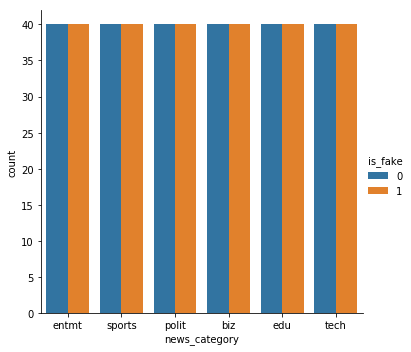

In [11]:
sns.catplot(x="news_category", kind = "count", hue="is_fake", data=perez_full)
plt.show()

In [12]:
perez_full.groupby(['news_category','is_fake']).size()

news_category  is_fake
biz            0          40
               1          40
edu            0          40
               1          40
entmt          0          40
               1          40
polit          0          40
               1          40
sports         0          40
               1          40
tech           0          40
               1          40
dtype: int64

## V. Create Feature-Enriched Training/Testing Datasets

## A. Implement Feature Creating Functions

#### 1. Ngram & Punctuation

In [13]:
train_data_vectorized, test_data_vectorized = tfidf_vectorizer_custom(
    train_data['news_all_clean'], test_data['news_all_clean'], ngram_range = (1,3))

Traing data info:
- Vocabulary len: 79354
- Longest phrase: httpeditioncnncom20170328footballfootballmessiargentinabanindexhtml argentina felt
- Smallest 10 phrases: ["'", 'is', 'to', 'in', 'be', 'on', 'as', 'of', 'if', 'hq']
- Sample of features: ["'" "' '" "' ' basketball" ... 'zuckerberg' 'zuckerberg is'
 'zuckerberg is the']


#### 2. Psycholinguistic features

In [14]:
train_data_LIWC = LIWC_counter(train_data, train_LIWC)
test_data_LIWC = LIWC_counter(test_data, test_LIWC)
train_data_LIWC.head()

,dataset_name,news_all,news_category,news_content,news_headline,news_all_clean,function,pronoun,ppron,i,...,home,money,relig,death,informal,swear,netspeak,assent,nonflu,filler
132,fakeNewsDataset,Real Madrid is willing to pay £100m for Eden H...,sports,"says Ramon Calderon ""Real Madrid are not in a ...",Real Madrid is willing to pay £100m for Eden H...,real madrid is willing to pay 100m for eden ha...,0.462766,0.042553,0.021277,0.005319,...,0.000000,0.026596,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
228,fakeNewsDataset,Women arrested three times is Melania Trump ...,polit,(CNN) A lady resembling Presidents Trump's wif...,Women arrested three times is Melania Trump,women arrested three times is melania trump ...,0.488372,0.127907,0.081395,0.000000,...,0.011628,0.011628,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
473,fakeNewsDataset,Alec Baldwin says he nearly passed on playing...,entmt,Alec Baldwin has revealed that he almost passe...,Alec Baldwin says he nearly passed on playing...,alec baldwin says he nearly passed on playing...,0.482143,0.138393,0.084821,0.035714,...,0.000000,0.013393,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
42,fakeNewsDataset,Will Smith reunites with Fresh Prince Pals to ...,entmt,Will Smith is back together with the cast of T...,Will Smith reunites with Fresh Prince Pals to ...,will smith reunites with fresh prince pals to ...,0.422535,0.070423,0.035211,0.007042,...,0.007042,0.007042,0.0,0.007042,0.000000,0.0,0.000000,0.0,0.0,0.0
360,fakeNewsDataset,"Instagram adds two-factor authentication, secu...",tech,Instagram just made your account harder to hac...,"Instagram adds two-factor authentication, secu...",instagram adds twofactor authentication securi...,0.306452,0.064516,0.048387,0.000000,...,0.000000,0.016129,0.0,0.000000,0.016129,0.0,0.016129,0.0,0.0,0.0


### B. Unify All Features in Single Dataset

In [15]:
def add_feature(sparse, df_to_sparse, df_ignore):
    """
    Returns sparse feature matrix with added feature.
    """
    return hstack([coo_matrix(df_to_sparse.drop(df_ignore.columns.values, axis = 1)),sparse])

In [16]:
#1. Combine ngram and LIWC
train_ngram_LIWC = add_feature(train_data_vectorized, train_data_LIWC, train_data)
test_ngram_LIWC = add_feature(test_data_vectorized, test_data_LIWC, test_data)

#5. Add news category
vectorizer = CountVectorizer()
vectorizer.fit(train_data['news_category'])
train_news_category_vec = vectorizer.transform(train_data['news_category'])
test_news_category_vec  = vectorizer.transform(test_data['news_category'])
train_final = hstack([train_ngram_LIWC,train_news_category_vec])
test_final =  hstack([test_ngram_LIWC,test_news_category_vec])

In [17]:
train_final

<384x79360 sparse matrix of type '<class 'numpy.float64'>'
	with 121088 stored elements in COOrdinate format>

## V. Classification Models with Automated Machine Learning (TPOT)

#### 1. Run TPOT Optimizer

In [18]:
pipeline_optimizer = TPOTClassifier(generations=5, population_size=20, cv=5,
                                    random_state=42, verbosity=2,
                                   config_dict = "TPOT sparse")
#pipeline_optimizer.fit(train_final, train_labels) #This takes a couple hours to run

#### 2. Output TPOT Algorithm

In [19]:
#pipeline_optimizer.export('tpot_ngram_LIWC.py')

#### 3. Implement TPOT Algorithm

In [20]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

exported_pipeline = make_pipeline(
    SelectPercentile(score_func=f_classif, percentile=21),
    XGBClassifier(learning_rate=0.001, max_depth=2, min_child_weight=4, n_estimators=100, nthread=1, subsample=0.25)
)


exported_pipeline.fit(train_final, train_labels)
ORIG_results = exported_pipeline.predict(test_final)
ORIG_proba = exported_pipeline.predict_proba(test_final)
print("accuracy on original test set: ",np.mean(ORIG_results == test_labels))

accuracy on original test set:  0.6145833333333334


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


#### 4. Output TPOT Model Report

Original Test Set Report
---------
             precision    recall  f1-score   support

          0       0.62      0.61      0.62        49
          1       0.60      0.62      0.61        47

avg / total       0.61      0.61      0.61        96



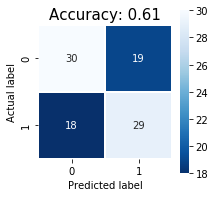

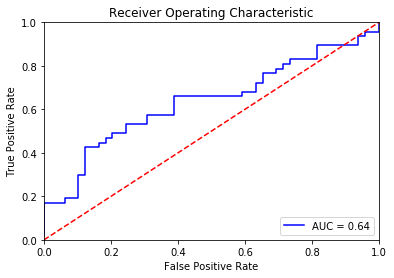

In [21]:
model_report("Original Test Set Report", test_labels, ORIG_results, ORIG_proba[:,1])